<a href="https://colab.research.google.com/github/ZazzyDictionary/SPY-experiment/blob/main/SPY_PA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


In [22]:
stocks = ["SPY"]

In [26]:
data = yf.download(stocks, start="1993-01-01", end="2021-02-10")

[*********************100%***********************]  1 of 1 completed


In [34]:
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,531500


In [28]:
closedStocks = data.loc[:, "Close"].copy()

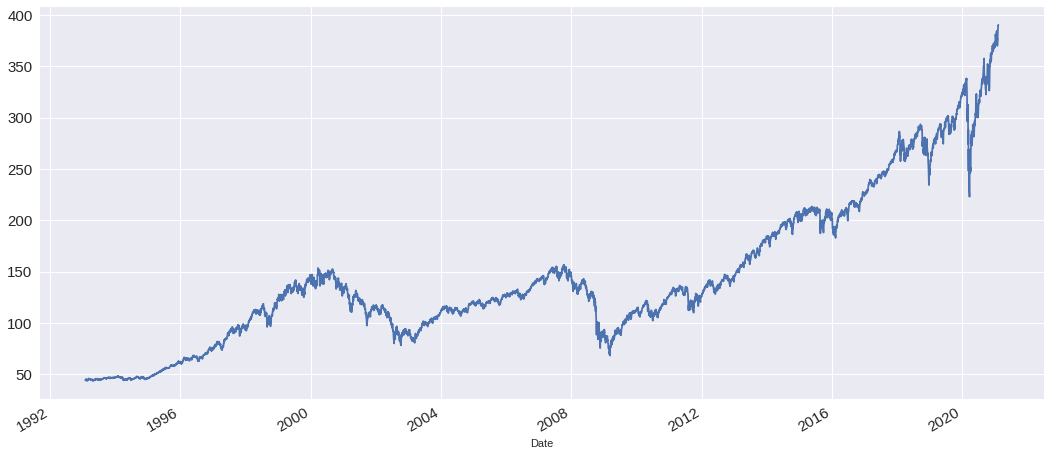

In [29]:
closedStocks.plot(figsize = (18, 8), fontsize = 15)
plt.style.use("seaborn")
plt.show()

In [35]:
data.drop("Close",axis=1,inplace=True)
data.to_csv("GSPC.csv")

In [41]:
df=pd.read_csv("GSPC.csv")
df.index=pd.to_datetime(df["Date"])
df=df.drop("Date",axis=1)

In [42]:
dfm=df.resample("M").mean()

dfm=dfm[:-1] # As we said, we do not consider the month of end_date

print(dfm.head())
print(dfm.tail())

                 Open       High        Low        Volume
Date                                                     
1993-01-31  43.968750  43.968750  43.750000  1.003200e+06
1993-02-28  44.305921  44.449013  44.049342  2.851368e+05
1993-03-31  45.082880  45.270380  44.937500  1.312696e+05
1993-04-30  44.446429  44.566964  44.215774  1.284381e+05
1993-05-31  44.625000  44.793750  44.465625  9.040000e+04
                  Open        High         Low        Volume
Date                                                        
2020-09-30  337.003809  339.645236  333.019998  8.641920e+07
2020-10-31  341.394999  343.884090  338.829093  7.405668e+07
2020-11-30  354.543997  356.509000  352.009499  7.676222e+07
2020-12-31  368.648181  370.576359  367.074548  6.113496e+07
2021-01-31  378.422632  380.472105  375.759475  7.380083e+07


In [45]:
start_date=datetime.datetime(1993, 1, 1)
end_date=datetime.datetime(2021,2,10)

start_year=start_date.year
start_month=start_date.month
end_year=end_date.year
end_month=end_date.month

first_days=[]
# First year
for month in range(start_month,13):
    first_days.append(min(df[str(start_year)+"-"+str(month)].index))
# Other years
for year in range(start_year+1,end_year):
    for month in range(1,13):
        first_days.append(min(df[str(year)+"-"+str(month)].index))
# Last year
for month in range(1,end_month+1):
    first_days.append(min(df[str(end_year)+"-"+str(month)].index))

In [46]:
dfm["fd_cm"]=first_days[:-1]
dfm["fd_nm"]=first_days[1:]
dfm["fd_cm_open"]=np.array(df.loc[first_days[:-1],"Open"])
dfm["fd_nm_open"]=np.array(df.loc[first_days[1:],"Open"])
dfm["rapp"]=dfm["fd_nm_open"].divide(dfm["fd_cm_open"])

In [47]:
print(dfm.head())
print(dfm.tail())

                 Open       High        Low  ...  fd_cm_open fd_nm_open      rapp
Date                                         ...                                 
1993-01-31  43.968750  43.968750  43.750000  ...    43.96875   43.96875  1.000000
1993-02-28  44.305921  44.449013  44.049342  ...    43.96875   44.56250  1.013504
1993-03-31  45.082880  45.270380  44.937500  ...    44.56250   45.25000  1.015428
1993-04-30  44.446429  44.566964  44.215774  ...    45.25000   44.09375  0.974448
1993-05-31  44.625000  44.793750  44.465625  ...    44.09375   45.37500  1.029057

[5 rows x 9 columns]
                  Open        High  ...  fd_nm_open      rapp
Date                                ...                      
2020-09-30  337.003809  339.645236  ...  337.690002  0.964250
2020-10-31  341.394999  343.884090  ...  330.200012  0.977820
2020-11-30  354.543997  356.509000  ...  365.570007  1.107117
2020-12-31  368.648181  370.576359  ...  375.309998  1.026643
2021-01-31  378.422632  380.4721

In [48]:
dfm["mv_avg_12"]= dfm["Open"].rolling(window=12).mean().shift(1)
dfm["mv_avg_24"]= dfm["Open"].rolling(window=24).mean().shift(1)

In [49]:
dfm=dfm.iloc[24:,:] # WARNING: DO IT JUST ONE TIME!
print(dfm.index)

DatetimeIndex(['1995-01-31', '1995-02-28', '1995-03-31', '1995-04-30',
               '1995-05-31', '1995-06-30', '1995-07-31', '1995-08-31',
               '1995-09-30', '1995-10-31',
               ...
               '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31',
               '2020-08-31', '2020-09-30', '2020-10-31', '2020-11-30',
               '2020-12-31', '2021-01-31'],
              dtype='datetime64[ns]', name='Date', length=313, freq='M')


In [50]:
mtest=72
train=dfm.iloc[:-mtest,:] 
test=dfm.iloc[-mtest:,:] 

In [51]:
# This function returns the total percentage gross yield and the annual percentage gross yield

def yield_gross(df,v):
    prod=(v*df["rapp"]+1-v).prod()
    n_years=len(v)/12
    return (prod-1)*100,((prod**(1/n_years))-1)*100

In [52]:
tax_cg=0.26
comm_bk=0.001

In [53]:
# This function will be used in the function yield_net

# Given any vector v of ones and zeros, this function gives the corresponding vectors of "islands" of ones of v
# and their number. 
# For example, given v = [0,1,1,0,1,0,1], expand_islands2D gives
# out2D = [[0,1,1,0,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,0,1]] and N=3

def expand_islands2D(v):
    
    # Get start, stop of 1s islands
    v1 = np.r_[0,v,0]
    idx = np.flatnonzero(v1[:-1] != v1[1:])
    s0,s1 = idx[::2],idx[1::2]
    if len(s0)==0:
        return np.zeros(len(v)),0
    
    # Initialize 1D id array  of size same as expected o/p and has 
    # starts and stops assigned as 1s and -1s, so that a final cumsum
    # gives us the desired o/p
    N,M = len(s0),len(v)
    out = np.zeros(N*M,dtype=int)

    # Setup starts with 1s
    r = np.arange(N)*M
    out[s0+r] = 1


    # Setup stops with -1s
    if s1[-1] == M:
        out[s1[:-1]+r[:-1]] = -1
    else:
        out[s1+r] -= 1

    # Final cumsum on ID array
    out2D = out.cumsum().reshape(N,-1)
    return out2D,N

In [54]:
# This function returns the total percentage net yield and the annual percentage net yield

def yield_net(df,v):
    n_years=len(v)/12
    
    w,n=expand_islands2D(v)
    A=(w*np.array(df["rapp"])+(1-w)).prod(axis=1)  # A is the product of each island of ones of 1 for df["rapp"]
    A1p=np.maximum(0,np.sign(A-1)) # vector of ones where the corresponding element if  A  is > 1, other are 0
    Ap=A*A1p # vector of elements of A > 1, other are 0
    Am=A-Ap # vector of elements of A <= 1, other are 0
    An=Am+(Ap-A1p)*(1-tax_cg)+A1p
    prod=An.prod()*((1-comm_bk)**(2*n)) 
    
    return (prod-1)*100,((prod**(1/n_years))-1)*100 

In [55]:
def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [57]:
dfm.info(
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313 entries, 1995-01-31 to 2021-01-31
Freq: M
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Open        313 non-null    float64       
 1   High        313 non-null    float64       
 2   Low         313 non-null    float64       
 3   Volume      313 non-null    float64       
 4   fd_cm       313 non-null    datetime64[ns]
 5   fd_nm       313 non-null    datetime64[ns]
 6   fd_cm_open  313 non-null    float64       
 7   fd_nm_open  313 non-null    float64       
 8   rapp        313 non-null    float64       
 9   mv_avg_12   313 non-null    float64       
 10  mv_avg_24   313 non-null    float64       
dtypes: datetime64[ns](2), float64(9)
memory usage: 29.3 KB


In [61]:
scaler=MinMaxScaler(feature_range=(0,1))
dg=pd.DataFrame(scaler.fit_transform(dfm[["High","Low","Open","Volume","rapp","fd_cm_open",\
                                          "mv_avg_12","mv_avg_24","fd_nm_open"]].values))
dg0=dg[[0,1,2,3,4,5,6,7]]


window=4
dfw=create_window(dg0,window)

X_dfw=np.reshape(dfw.values,(dfw.shape[0],window+1,8))
print(X_dfw.shape)
print(dfw.iloc[:4,:])
print(X_dfw[0,:,:])

y_dfw=np.array(dg[8][window:])

(309, 5, 8)
          0         1         2  ...         5         6         7
0  0.000000  0.000000  0.000000  ...  0.017729  0.002998  0.002752
1  0.005505  0.005503  0.005417  ...  0.023371  0.005222  0.004015
2  0.008759  0.008557  0.008600  ...  0.026594  0.007745  0.005454
3  0.013016  0.013011  0.013055  ...  0.031951  0.010955  0.007201

[4 rows x 40 columns]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.27740137e-01 0.00000000e+00 2.32295191e-04 0.00000000e+00]
 [5.50526387e-03 5.50294363e-03 5.41675755e-03 3.51604541e-04
  6.48560531e-01 4.40866111e-03 0.00000000e+00 4.05533464e-04]
 [8.75929055e-03 8.55733051e-03 8.59972894e-03 1.26806996e-04
  6.00085790e-01 9.90763625e-03 2.80155898e-04 1.04489040e-03]
 [1.30163770e-02 1.30106542e-02 1.30552210e-02 1.92678209e-04
  6.19003513e-01 1.33207932e-02 1.13326986e-03 1.72899218e-03]
 [1.83151842e-02 1.79628333e-02 1.81148331e-02 3.59627932e-04
  6.41147674e-01 1.77294543e-02 2.99798752e-03 2.75169248e-03]]


In [62]:
X_trainw=X_dfw[:-mtest-1,:,:]
X_testw=X_dfw[-mtest-1:,:,:]
y_trainw=y_dfw[:-mtest-1]
y_testw=y_dfw[-mtest-1:]

In [63]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(LSTM(300, input_shape = (window,features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200, input_shape=(window,features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer='adam')
    
    
    return model

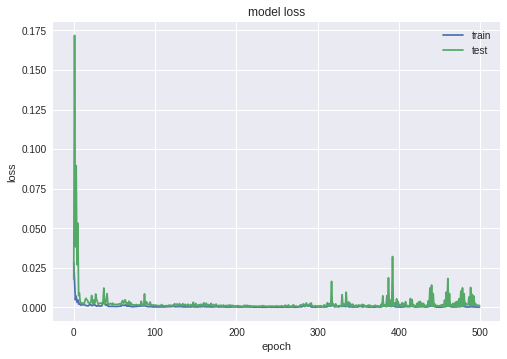

In [64]:
model=model_lstm(window+1,8)
history=model.fit(X_trainw,y_trainw,epochs=500, batch_size=24, validation_data=(X_testw, y_testw), \
                  verbose=0, callbacks=[],shuffle=False)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [66]:
y_pr=model.predict(X_trainw)

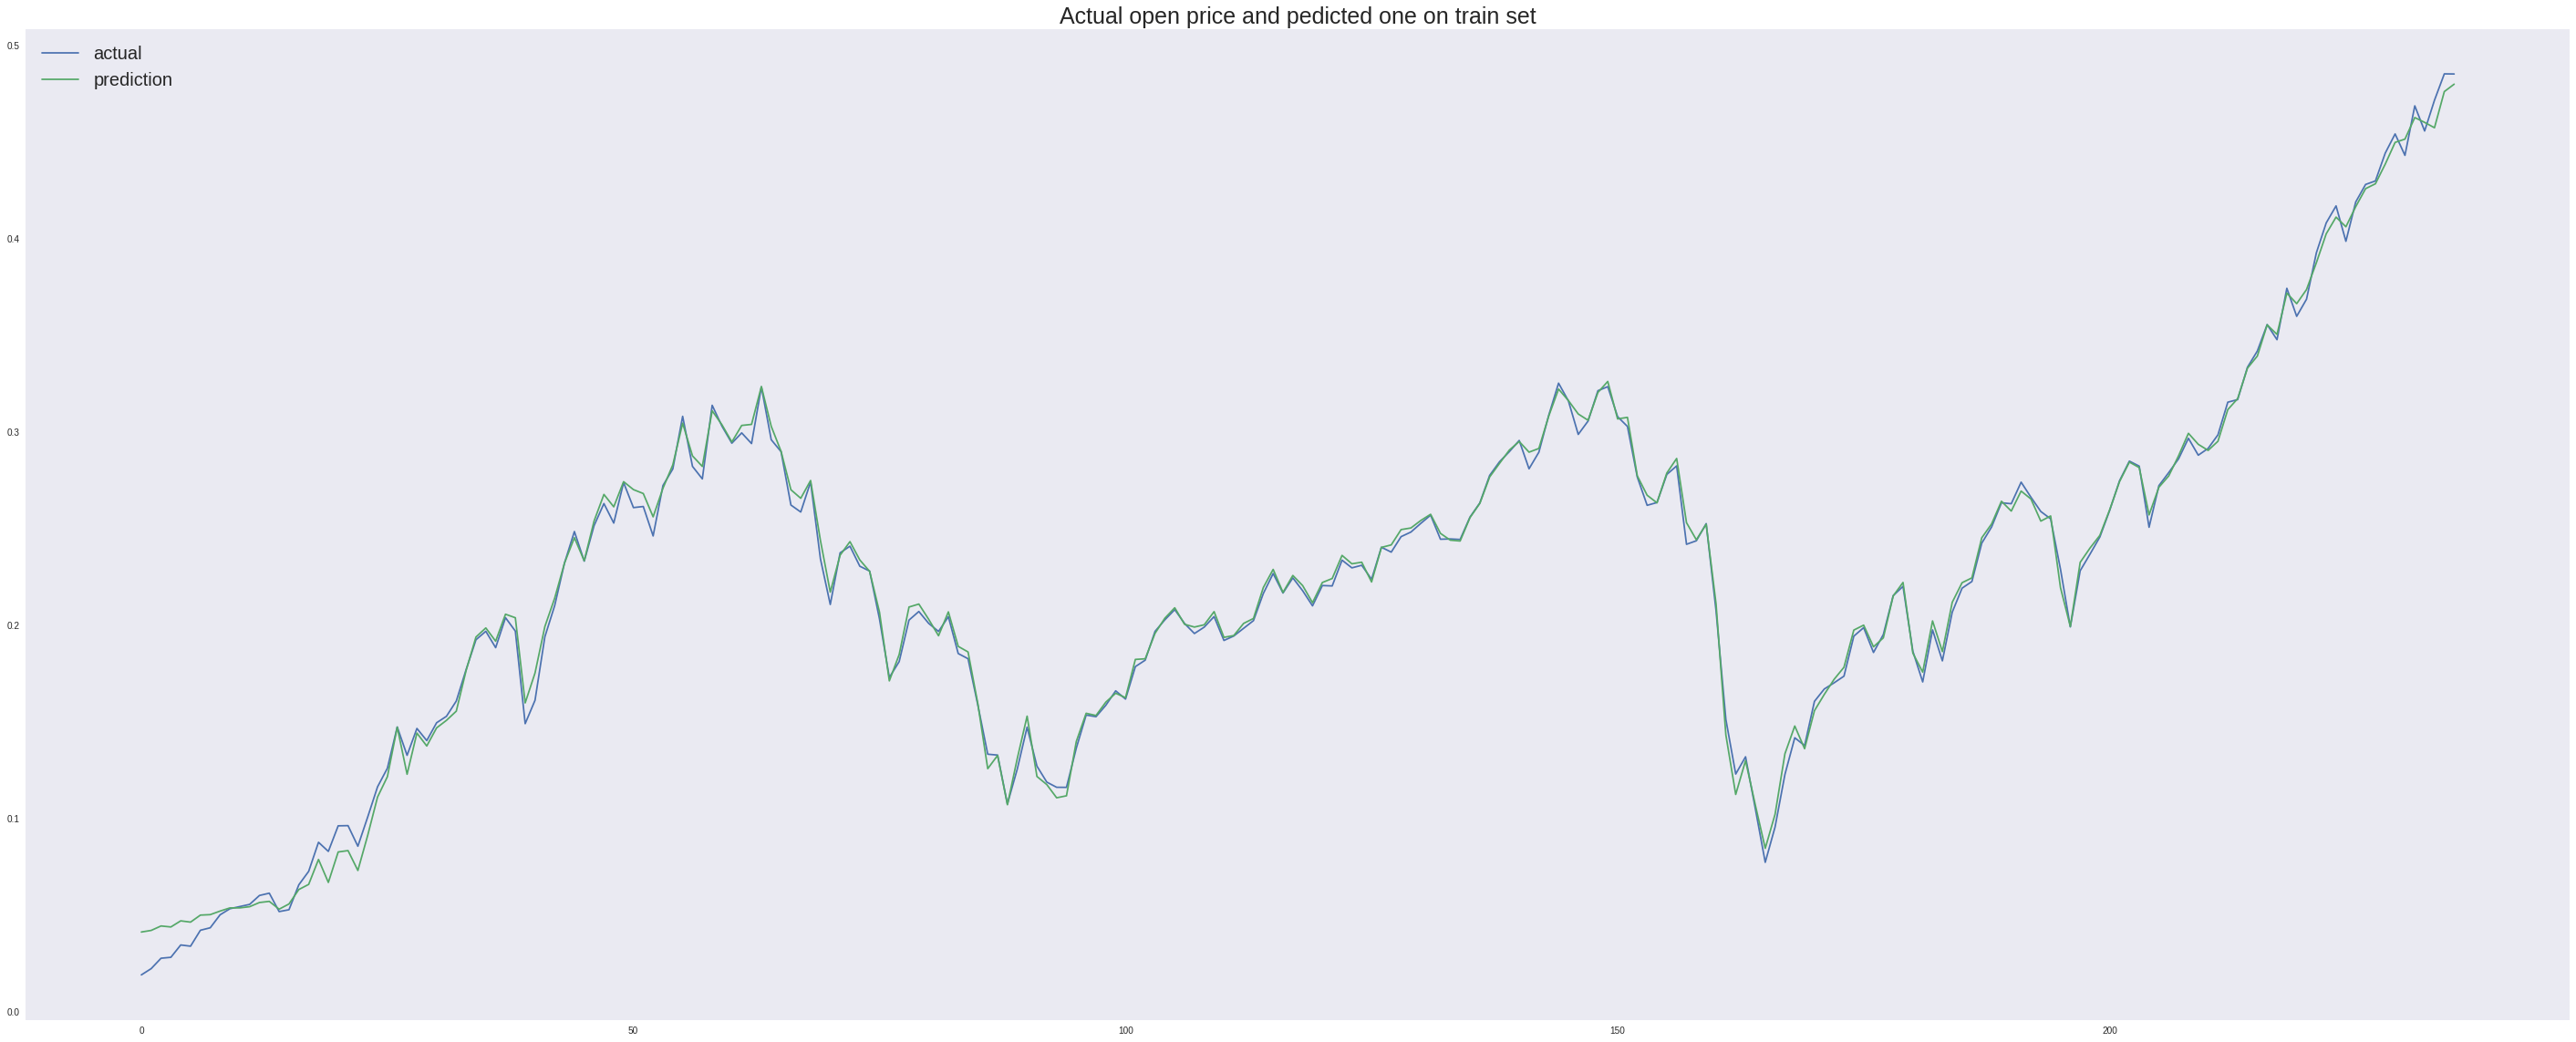

In [74]:
plt.figure(figsize=(50,20))
plt.plot(y_trainw, label="actual")
plt.plot(y_pr, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price and pedicted one on train set",fontsize=25)
plt.show()

In [68]:
y_pred=model.predict(X_testw)

In [69]:
v=np.diff(y_pred.reshape(y_pred.shape[0]),1)
v_lstm=np.maximum(np.sign(v),0)


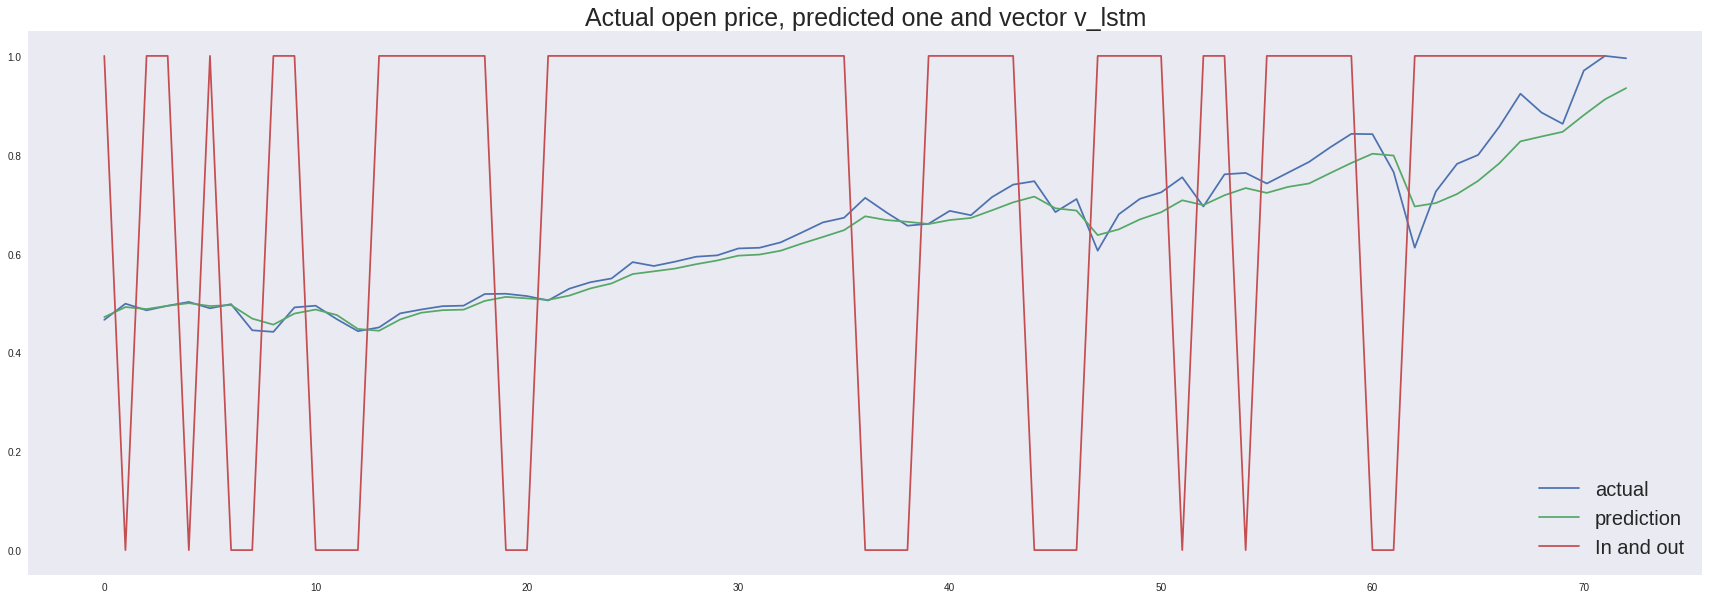

In [70]:
plt.figure(figsize=(30,10))
plt.plot(y_testw, label="actual")
plt.plot(y_pred, label="prediction")
plt.plot(v_lstm,label="In and out")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual open price, predicted one and vector v_lstm",fontsize=25)
plt.show()